In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import os
os.listdir('/kaggle/input/spot-the-mask/')

['sample_sub.csv', 'train_labels.csv', 'images']

In [3]:
def random_seed(seed_value):
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
train_df = pd.read_csv('/kaggle/input/spot-the-mask/train_labels.csv')
test_df = pd.read_csv('/kaggle/input/spot-the-mask/sample_sub.csv')

In [5]:
train_df.head(3)

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0


In [6]:
test_df['+ACI-image+ACI-'] = test_df['+ACI-image+ACI-'].str.replace(r'\+ACI\-','',regex=True)
test_df.head(2)

,+ACI-image+ACI-,+ACI-target+ACI-
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0


In [7]:
data_folder = Path('/kaggle/input/spot-the-mask/')

In [8]:
random_seed(42)

test_img = ImageList.from_df(test_df, path=data_folder, folder='images')

trfm = get_transforms()

train_img = (ImageList.from_df(train_df, path=data_folder, folder='images')
        .split_by_rand_pct(0.1)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=224)
        .databunch(path='.', bs=32, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

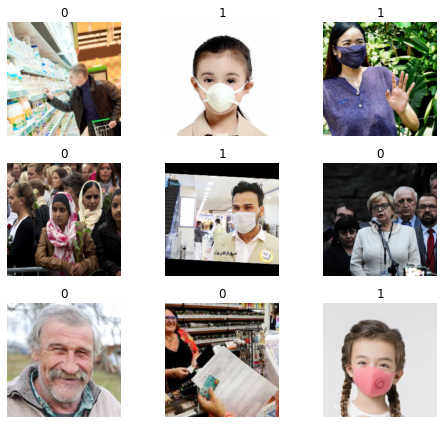

In [9]:
train_img.show_batch(rows=3, figsize=(7,6))

In [10]:
print(train_img.classes)
len(train_img.classes), train_img.c

[0, 1]


(2, 2)

In [11]:
random_seed(42)
learn = cnn_learner(train_img, models.resnet101, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [12]:
random_seed(42)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.425804,0.233544,0.046154,0.953846,00:35
1,0.382730,0.170256,0.038462,0.961538,00:32
2,0.268996,0.135729,0.030769,0.969231,00:33
3,0.205433,0.115987,0.023077,0.976923,00:32
4,0.163160,0.085944,0.046154,0.953846,00:34
5,0.119477,0.118703,0.046154,0.953846,00:33
6,0.090357,0.104452,0.030769,0.969231,00:33
7,0.075058,0.096805,0.038462,0.961538,00:32
8,0.068195,0.080395,0.030769,0.969231,00:32
9,0.052634,0.090114,0.023077,0.976923,00:34


In [13]:
learn.save('stage-1')

# Results

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(train_img.valid_ds)==len(losses)==len(idxs)

True

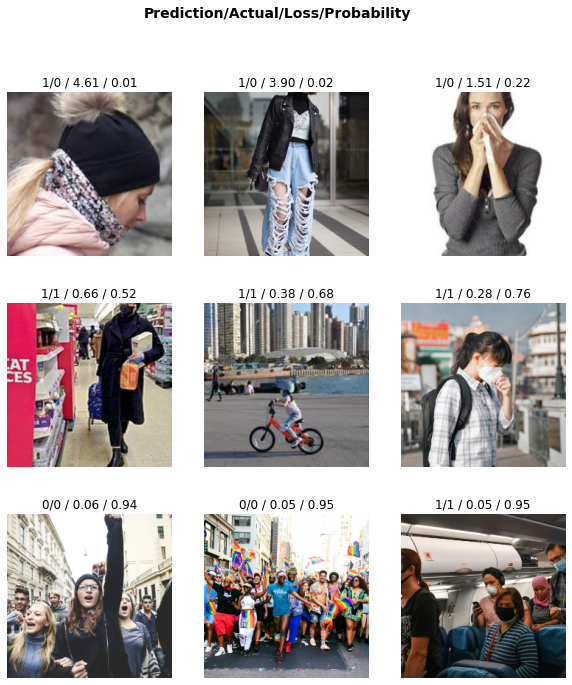

In [15]:
interp.plot_top_losses(9, figsize=(10,11))

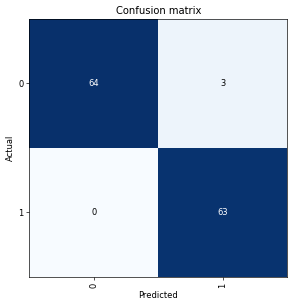

In [16]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [17]:
interp.most_confused(min_val=2)

[(0, 1, 3)]

# Unfreezing, fine-tuning, and learning rates

In [18]:
learn.unfreeze()

In [19]:
random_seed(42)
learn.freeze_to(-3)
learn.fit_one_cycle(5, wd=0.5)
learn.save('stage-2');

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.078727,0.280822,0.100000,0.900000,00:34
1,0.226218,0.112337,0.038462,0.961538,00:35
2,0.189451,0.052803,0.030769,0.969231,00:34
3,0.137463,0.050854,0.023077,0.976923,00:34
4,0.092895,0.040215,0.015385,0.984615,00:35


In [20]:
random_seed(42)
learn.freeze_to(-2)
learn.fit_one_cycle(5, wd=0.5)
learn.save('stage-3');

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.069879,0.238488,0.076923,0.923077,00:34
1,0.120191,0.312077,0.130769,0.869231,00:35
2,0.127503,0.223876,0.061538,0.938462,00:33
3,0.101170,0.099697,0.046154,0.953846,00:34
4,0.079673,0.076032,0.046154,0.953846,00:34


In [21]:
random_seed(42)
learn.freeze_to(-1)
learn.fit_one_cycle(5, wd=0.5)
learn.save('stage-4');

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.030777,0.094036,0.038462,0.961538,00:33
1,0.045175,0.085711,0.046154,0.953846,00:34
2,0.039192,0.068708,0.038462,0.961538,00:32
3,0.022464,0.122321,0.046154,0.953846,00:33
4,0.033333,0.111018,0.038462,0.961538,00:33


In [22]:
import numpy as np
import pandas as pd

In [23]:
learn.load('stage-4')
log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test)

In [24]:
log_preds

tensor([[9.9916e-01, 8.3781e-04],
        [9.9999e-01, 7.0935e-06],
        [3.2075e-04, 9.9968e-01],
        ...,
        [9.9990e-01, 1.0408e-04],
        [5.5267e-05, 9.9994e-01],
        [5.2586e-04, 9.9947e-01]])

In [25]:
np.array(log_preds).shape

(509, 2)

In [26]:
pred = np.array(log_preds)[:,1]

In [27]:
test_df['+ACI-target+ACI-'] = pred
test_df.head(3)

,+ACI-image+ACI-,+ACI-target+ACI-
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0.000838
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0.000007
2,aclkjfvackiieiznzfcwienplielrj.jpg,0.999679


In [28]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(test_df)